##### Copyright 2022 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gesture Recognizer with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to recognize hand gestures in images.

## Preparation

Let's start with installing MediaPipe.

*Notes:*
* *If you see an error about `flatbuffers` incompatibility, it's fine to ignore it. MediaPipe requires a newer version of flatbuffers (v2), which is incompatible with the older version of Tensorflow (v2.9) currently preinstalled on Colab.*
* *If you install MediaPipe outside of Colab, you only need to run `pip install mediapipe`. It isn't necessary to explicitly install `flatbuffers`.*

In [1]:
!pip install -q flatbuffers==2.0.0
!pip install -q mediapipe==0.9.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 2.0 which is incompatible.
     |████████████████████████████████| 33.0 MB 178 kB/s 


Then download an off-the-shelf model. This model can recognize 7 hand gestures: 👍, 👎, ✌️, ☝️, ✊, 👋, 🤟

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/gesture_recognizer#models) for more details about the model.

In [2]:
!wget -q https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/gesture_recognizer.task

## Visualization Utilities

In [15]:
#@markdown We implemented some functions to visualize the gesture recognition results. <br/> Run the following cell to activate the functions.
from matplotlib import pyplot as plt
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2

plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'xtick.labelbottom': False,
    'xtick.bottom': False,
    'ytick.labelleft': False,
    'ytick.left': False,
    'xtick.labeltop': False,
    'xtick.top': False,
    'ytick.labelright': False,
    'ytick.right': False
})

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles


def display_one_image(image, title, subplot, titlesize=16):
    """Displays one image along with the predicted category name and score."""
    plt.subplot(*subplot)
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize), color='black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch_of_images_with_gestures_and_hand_landmarks(images, results):
    """Displays a batch of images with the gesture category and its score along with the hand landmarks."""
    # Images and labels.
    images = [image.numpy_view() for image in images]
    gestures = [top_gesture for (top_gesture, _) in results]
    multi_hand_landmarks_list = [multi_hand_landmarks for (_, multi_hand_landmarks) in results]

    # Auto-squaring: this will drop data that does not fit into square or square-ish rectangle.
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows

    # Size and spacing.
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # Display gestures and hand landmarks.
    for i, (image, gestures) in enumerate(zip(images[:rows*cols], gestures[:rows*cols])):
        title = f"{gestures.category_name} ({gestures.score:.2f})"
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols) * 40 + 3
        annotated_image = image.copy()

        for hand_landmarks in multi_hand_landmarks_list[i]:
          hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
          hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
          ])

          mp_drawing.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

        subplot = display_one_image(annotated_image, title, subplot, titlesize=dynamic_titlesize)

    # Layout.
    plt.tight_layout()
    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

## Download test images

Let's grab some test images that we'll use later.

In [17]:
import urllib

IMAGE_FILENAMES = ['fist.jpg', 'victory.jpg', 'thumb_up.jpg', 'pointing_up.jpg']

for name in IMAGE_FILENAMES:
  url = f'https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/{name}'
  urllib.request.urlretrieve(url, name)

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [ ]:
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)
# IMAGE_FILENAMES = list(uploaded.keys())

# print('Uploaded files:', IMAGE_FILENAMES)

Then let's check out the images.

fist.jpg


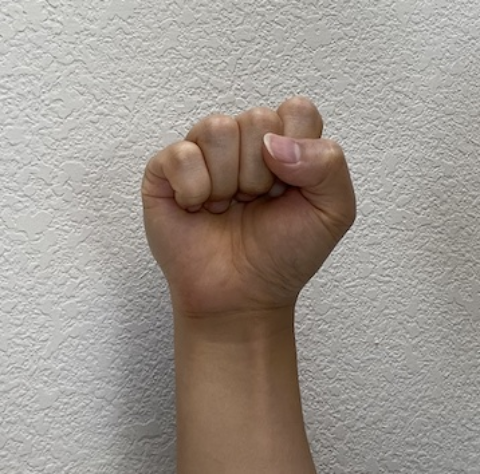

victory.jpg


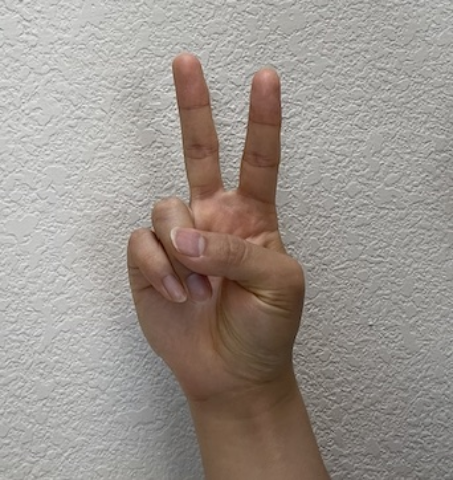

thumb_up.jpg


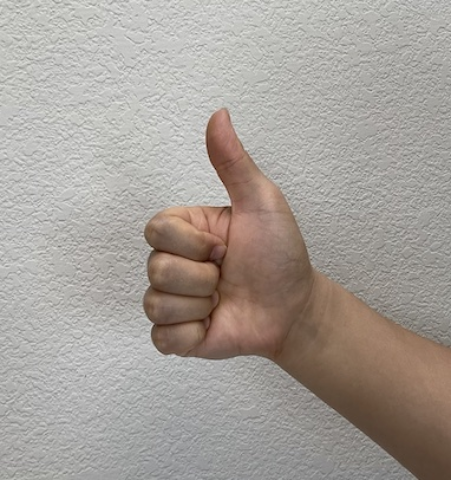

pointing_up.jpg


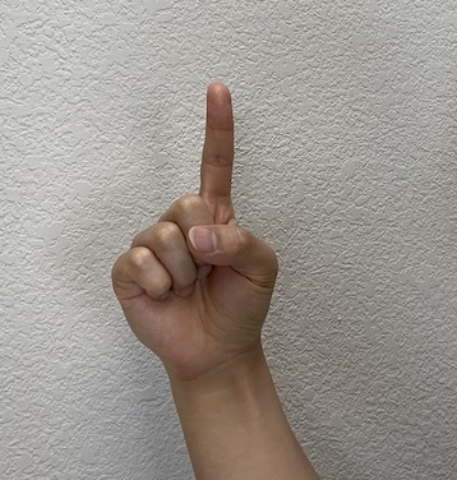

In [18]:
import cv2

from google.colab.patches import cv2_imshow
import math

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)


# Preview the images.
images = {name: cv2.imread(name) for name in IMAGE_FILENAMES}
for name, image in images.items():
  print(name)
  resize_and_show(image)

## Running inference and visualizing the results

Here are the steps to run gesture recognizer using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/gesture_recognizer/python) to learn more about configuration options that this solution supports.

*Note: Gesture Recognizer also returns the hand landmark it detects from the image, together with other useful information such as whether the hand(s) detected are left hand or right hand.*

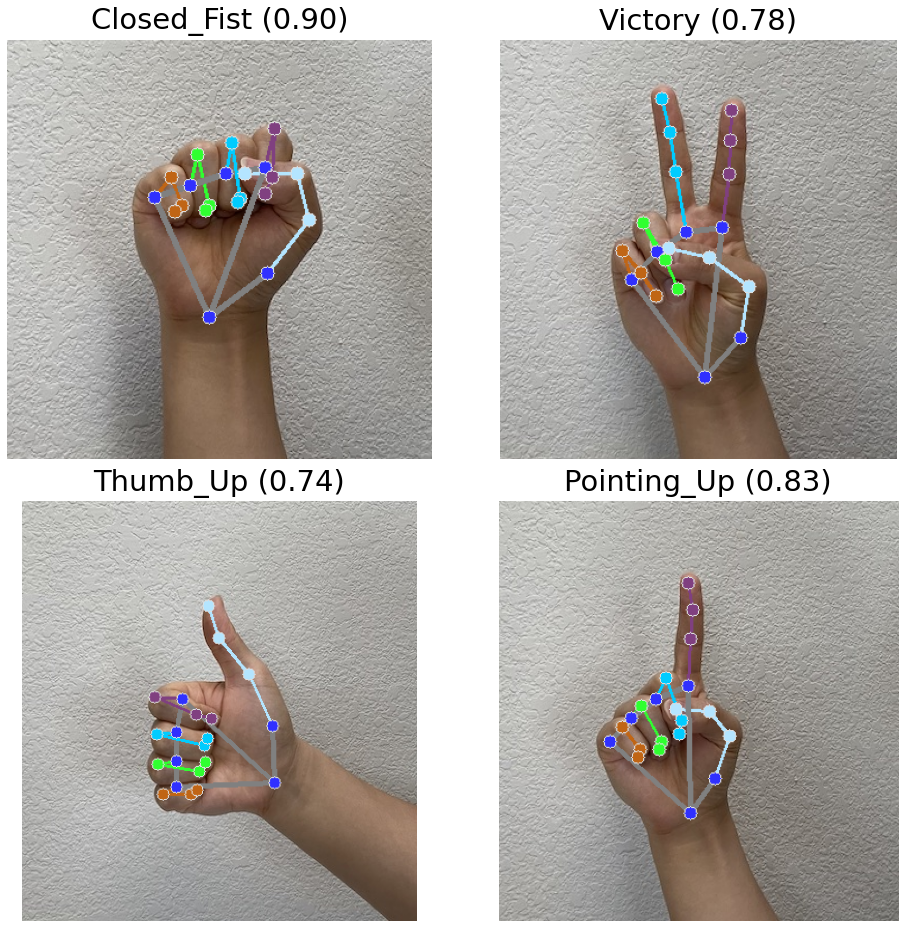

In [19]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an GestureRecognizer object.
base_options = python.BaseOptions(model_asset_path='gesture_recognizer.task')
options = vision.GestureRecognizerOptions(base_options=base_options)
recognizer = vision.GestureRecognizer.create_from_options(options)

images = []
results = []
for image_file_name in IMAGE_FILENAMES:
  # STEP 3: Load the input image.
  image = mp.Image.create_from_file(image_file_name)

  # STEP 4: Recognize gestures in the input image.
  recognition_result = recognizer.recognize(image)

  # STEP 5: Process the result. In this case, visualize it.
  images.append(image)
  top_gesture = recognition_result.gestures[0][0]
  hand_landmarks = recognition_result.hand_landmarks
  results.append((top_gesture, hand_landmarks))

display_batch_of_images_with_gestures_and_hand_landmarks(images, results)